# Solving the collision-coalescence ODE with machine learning models

### Load Tensorflow and other useful modules

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [2]:
import numpy as np
import xarray as xarray
import os.path

# Load the DNN models

In [3]:
def load_model(model_name):
    filename = 'saved_model_v9/'+model_name
    if os.path.isdir(filename):
        model = tf.keras.models.load_model(filename)
    else:
        print('File not found: '+filename)
        model = False
    return model

In [4]:

#param='sigm_32x32x32_big_n5_z12'
param='ReLU_32x32x32_big_n5_z12'
#param='PReLU_32x32x32_big_n5_z12'
#param='tanh_32x32x32_big_n5_z12'
#param='ReLU_deep_32_big_n5_z12'

ml_string1 = 'one4all_LcXcLrXrNu_02_'+param
ml_string2 = 'one4all_LcNcLrNrNu_02_'+param
ml_string3 = 'one4all_NcXcNrXrNu_02_'+param

model1 = load_model(ml_string1)
model2 = load_model(ml_string2)
model3 = load_model(ml_string3)


In [5]:
# Check its architecture
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                192       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 132       
Total params: 2,436
Trainable params: 2,436
Non-trainable params: 0
_________________________________________________________________


In [6]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                192       
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 132       
Total params: 2,436
Trainable params: 2,436
Non-trainable params: 0
_________________________________________________________________


### load normalization as pandas dataframe

In [7]:
def load_normalization(model_name,string):
    filename = 'saved_model_v9/'+model_name+'_'+string+'.pickle'
    if os.path.isfile(filename):
        norm = pd.read_pickle(filename)
    else:
        print('File not found: '+filename) 
        norm = False
    return norm

In [8]:
norm1 = load_normalization(ml_string1,'norm')
norm2 = load_normalization(ml_string2,'norm')
norm3 = load_normalization(ml_string3,'norm')

labels_norm1 = load_normalization(ml_string1,'labels')
labels_norm2 = load_normalization(ml_string2,'labels')
labels_norm3 = load_normalization(ml_string3,'labels')

In [9]:
norm1

count       mean       std        min        25%        50%        75%  \
Lc  157586.0  -8.303328  1.073201 -14.710634  -8.761376  -8.313967  -7.472261   
Xc  157586.0 -25.736496  0.512274 -28.268673 -26.123384 -25.816530 -25.339688   
Lr  157586.0 -10.320187  2.403249 -20.693756 -12.148037  -9.957234  -8.300186   
Xr  157586.0 -18.927074  2.124871 -22.034079 -20.689145 -19.410274 -17.519808   
nu  157586.0   1.918787  1.395136   0.000000   1.000000   2.000000   3.000000   

          max  
Lc  -6.215789  
Xc -24.881920  
Lr  -6.217086  
Xr -10.602690  
nu   4.000000

In [10]:
norm2

count       mean       std        min        25%        50%        75%  \
Lc  157586.0  -8.303328  1.073201 -14.710634  -8.761376  -8.313967  -7.472261   
Nc  157586.0  17.437563  1.150774  11.050814  16.732211  17.516932  18.250502   
Lr  157586.0 -10.320187  2.403249 -20.693756 -12.148037  -9.957234  -8.300186   
Nr  157586.0   8.606781  1.573649   0.919470   7.542385   8.626649   9.731326   
nu  157586.0   1.918787  1.395136   0.000000   1.000000   2.000000   3.000000   

          max  
Lc  -6.215789  
Nc  20.245541  
Lr  -6.217086  
Nr  13.366846  
nu   4.000000

In [11]:
norm3

count       mean       std        min        25%        50%        75%  \
Xc  157586.0 -25.736496  0.512274 -28.268673 -26.123384 -25.816530 -25.339688   
Nc  157586.0  17.437563  1.150774  11.050814  16.732211  17.516932  18.250502   
Xr  157586.0 -18.927074  2.124871 -22.034079 -20.689145 -19.410274 -17.519808   
Nr  157586.0   8.606781  1.573649   0.919470   7.542385   8.626649   9.731326   
nu  157586.0   1.918787  1.395136   0.000000   1.000000   2.000000   3.000000   

          max  
Xc -24.881920  
Nc  20.245541  
Xr -10.602690  
Nr  13.366846  
nu   4.000000

In [12]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

def norm_inv(x,stats):
  return (x * stats['std'] + stats['mean'])


# Define the callable parameterization functions

In [13]:
xstar = 2.6e-10   # xstar in kg
eps = 1e-10

def warmrain1(qc,xc,qr,xr,nu):
    qc = np.where(qc < eps,eps,qc)  # make sure we are within the training data
    qr = np.where(qr < eps,eps,qr)  # make sure we are within the training data
    data = pd.DataFrame(np.array( [ np.log(qc.ravel()), np.log(xc.ravel()), np.log(qr.ravel()), np.log(xr.ravel()), nu.ravel() ]))
    data = data.T
    data.columns = [ 'Lc','Xc','Lr','Xr','nu' ] 
    pdata = pd.DataFrame(data=model1.predict(norm(data,norm1)), columns=["auto", "accr","selfc","selfr"])
#    print(pdata.describe())
    predict = np.exp(norm_inv(pdata,labels_norm1))    
    au = np.reshape(predict['auto'].to_numpy(),qc.shape) 
    ac = np.reshape(predict['accr'].to_numpy(),qc.shape) 
    sc_c = np.reshape(predict['selfc'].to_numpy(),qc.shape) 
    sc_r = np.reshape(predict['selfr'].to_numpy(),qc.shape) 
    return au, ac, sc_c, sc_r

def warmrain2(qc,nc,qr,nr,nu):
    qc = np.where(qc < eps,eps,qc)  # make sure we are within the training data
    qr = np.where(qr < eps,eps,qr)  # make sure we are within the training data
    nc = np.where(nc < 1e2,1e2,nc)  # make sure we are within the training data
    nr = np.where(nr < 1e0,1e0,nr)  # make sure we are within the training data
    data = pd.DataFrame(np.array( [ np.log(qc.ravel()), np.log(nc.ravel()), np.log(qr.ravel()), np.log(nr.ravel()), nu.ravel() ]))
    data = data.T
    data.columns = [ 'Lc','Nc','Lr','Nr','nu' ] 
    pdata = pd.DataFrame(data=model2.predict(norm(data,norm2)), columns=["auto", "accr","selfc","selfr"])
    predict = np.exp(norm_inv(pdata,labels_norm2))    
    au = np.reshape(predict['auto'].to_numpy(),qc.shape) 
    ac = np.reshape(predict['accr'].to_numpy(),qc.shape) 
    sc_c = np.reshape(predict['selfc'].to_numpy(),qc.shape) 
    sc_r = np.reshape(predict['selfr'].to_numpy(),qc.shape) 
    return au, ac, sc_c, sc_r

def warmrain3(nc,xc,nr,xr,nu):
    nc = np.where(nc < 1e2,1e2,nc)      # make sure we are within the training data
    nr = np.where(nr < 1e0,1e0,nr)      # make sure we are within the training data
    xr = np.where(xr < xstar,xstar,xr)  # make sure we are within the training data
    data = pd.DataFrame(np.array( [ np.log(nc.ravel()), np.log(xc.ravel()), np.log(nr.ravel()), np.log(xr.ravel()), nu.ravel() ]))
    data = data.T
    data.columns = [ 'Nc','Xc','Nr','Xr','nu' ] 
    pdata = pd.DataFrame(data=model3.predict(norm(data,norm3)), columns=["auto", "accr","selfc","selfr"])
    predict = np.exp(norm_inv(pdata,labels_norm3))    
    au = np.reshape(predict['auto'].to_numpy(),nc.shape) 
    ac = np.reshape(predict['accr'].to_numpy(),nc.shape) 
    sc_c = np.reshape(predict['selfc'].to_numpy(),nc.shape) 
    sc_r = np.reshape(predict['selfr'].to_numpy(),nc.shape) 
    return au, ac, sc_c, sc_r

# SB2001 warm-rain model

In [14]:

kcc = 9.44e9      # Long kernel in m3 kg-2 s-1 
kcr = 5.78        # Long kernel in m3 kg-1 s-1 
krr = 4.33

xstar = 2.6e-10   # xstar in kg
a_phi = 600.
p_phi = 0.68
#a_phi = 954.
#p_phi = 0.773

rhow = 1e3
def drop_mass(drop_radius):
    return 4./3. *np.pi * rhow * drop_radius**3

def autoconSB(qc,xc,nu,qr):
    auto = kcc/(20*xstar) * (nu+2.0)*(nu+4.0)/(nu+1.0)**2 * qc**2 * xc**2
    tau  = qr/(qc+qr+1e-15)
    taup = np.power(tau,p_phi)
    phi  = a_phi * taup * (1.0 - taup)**3
    auto = auto * (1.0+phi)
#    print("  qc=%0.3e"%qc[0,0]+",  xc=%0.3e"%xc[0,0]+",  qr=%0.3e"%qr[0,0]+",  nu=%2.1f"%nu+",  auto=%0.3e"%auto[0,0])
    return auto

def accretionSB(qc,qr):
    tau = qr/(qc+qr)
    phi = (tau / (tau + 5e-4))**4
    acc = kcr * qc * qr * phi
    return acc

def selfcloudSB(qc,nu):
    self = kcc * (nu+2.0)/(nu+1.0) * qc**2
    return self

def selfrainSB(qr,nr):
    self = krr * qr * nr
    return self

# Scalar sanity test of process rate parameterizations

In [15]:
qc = np.array(1.0e-3)
qr = np.array(0.1e-9)
nu = np.array(0.0)
rc = np.array(12e-6)
rr = np.array(100e-6)
xc = drop_mass(rc)
xr = drop_mass(rr)
nc = qc/xc
nr = qr/xr

### ML model

In [16]:
warmrain1(qc,xc,qr,xr,nu)

(array(1.6628311e-12, dtype=float32),
 array(4.1479892e-13, dtype=float32),
 array(4098.102, dtype=float32),
 array(3.4032413e-10, dtype=float32))

In [17]:
warmrain2(qc,nc,qr,nr,nu)

(array(8.759517e-12, dtype=float32),
 array(3.6724692e-13, dtype=float32),
 array(17278.947, dtype=float32),
 array(3.397286e-11, dtype=float32))

In [18]:
warmrain3(nc,xc,nr,xr,nu)

(array(8.791278e-10, dtype=float32),
 array(2.5909858e-10, dtype=float32),
 array(0.0464184, dtype=float32),
 array(0.22602533, dtype=float32))

In [19]:
au, ac, sc_c, sc_r = warmrain1(qc,xc,qr,xr,nu)

In [20]:
au

array(1.6628311e-12, dtype=float32)

In [21]:
ac

array(4.1479892e-13, dtype=float32)

In [22]:
sc_c

array(4098.102, dtype=float32)

In [23]:
sc_r

array(3.4032413e-10, dtype=float32)

### SB2001

In [24]:
autoconSB(qc,xc,nu,qr)

7.688258152443843e-10

In [25]:
accretionSB(qc,qr)

9.24060160221874e-28

In [26]:
selfcloudSB(qc,nu)

18880.0

In [27]:
selfrainSB(qr,nr)

1.03371135538186e-11

# Time loop

In [28]:
dt = 5  
models = 2

ltest_scalar = False     # a test-run with a scalar loop mostly for debugging
ltest_loop   = False     # a test-run with a small parameter space

# initial condition
if ltest_scalar:
    ntmax = 10
    qc0 = np.array( 2.0e-3 )
    rc0 = np.array( 13e-6 )
    nu0 = np.array( 1 )
    xc0 = drop_mass(rc0)
elif ltest_loop:
    ntmax = 720
    qc0 = np.array( [2.0e-3,5e-3] )
    rc0 = np.array( [13e-6,15e-6] )
    nu0 = np.array( [0,2] )
    xc0 = drop_mass(rc0)
else:
    ntmax = int(10800/dt)
    qc0 = np.array( [0.3e-3,0.5e-3,0.7e-3,1.0e-3,1.5e-3,2e-3] )
    rc0 = np.array( [10e-6, 11e-6, 12e-6, 13e-6, 14e-6, 15e-6] )
    nu0 = np.array( [0,1,2,3,4] )
    xc0 = drop_mass(rc0)
    xc0 = drop_mass(rc0)

tend = ntmax*dt

if ltest_scalar:
    nqc = 1
    nrc = 1
    nnu = 1
else:
    nqc = len(qc0)
    nrc = len(rc0)
    nnu = len(nu0)
    
dim = nqc*nrc*nnu

qc = np.zeros((models,nqc,nrc,nnu,ntmax))
qr = np.zeros((models,nqc,nrc,nnu,ntmax))
xc = np.zeros((models,nqc,nrc,nnu,ntmax))
xr = np.zeros((models,nqc,nrc,nnu,ntmax))
AU = np.zeros((models,nqc,nrc,nnu,ntmax))
AC = np.zeros((models,nqc,nrc,nnu,ntmax))
SCC = np.zeros((models,nqc,nrc,nnu,ntmax))
SCR = np.zeros((models,nqc,nrc,nnu,ntmax))
t10 = np.full((models,nqc,nrc,nnu),tend)
t50 = np.full((models,nqc,nrc,nnu),tend)

# a linear time coordinate
time = np.linspace(0,ntmax*dt,ntmax)

# simple integer coordinate for the models
models = np.array([0,1]) 

print("dim   = %d"%dim)
print("ntmax = %d"%ntmax)

dim   = 180
ntmax = 2160


### Here we integrate the whole 3d parameter space in parallel 

This is more efficient than individual (scalar) calls to the ML models. The downside is that we have to run all simulations over the full time interval and cannot stop when we haved reached t50 or 2*t50. Hence, patience is nevertheless needed. 

In [29]:

models  = 2  # this is always 2

MLmodel = 3  # choose ML model (here 1,2, or 3)

Nmin = 1e-15

qr0 = 0.0

for m in range(0,models):    
    print('m = %d'%m+' for MLmodel = %d'%MLmodel) 
    nt = 1
    if m == 0:
        nout = 1000
    else:
        nout = 100
    # initial condition    
    rc3d, Lc3d, nu3d = np.meshgrid(rc0,qc0,nu0)
    Xc3d = 4./3. * 3.14 * rhow * rc3d**3
    Nc3d = Lc3d/Xc3d
    Lr3d = np.full((nqc,nrc,nnu),qr0)
    Nr3d = np.full((nqc,nrc,nnu),Nmin)
    Xr3d = Lr3d/Nr3d
    Xr3d = np.where(Xr3d<xstar,xstar,Xr3d)
    qc[m,:,:,:,0] = Lc3d
    qr[m,:,:,:,0] = Lr3d   
    # start time loop    
    while nt < ntmax:
        if m == 0:
            auto = autoconSB(Lc3d,Xc3d,nu3d,Lr3d)
            accr = accretionSB(Lc3d,Lr3d)
            sc_c = selfcloudSB(Lc3d,nu3d)
            sc_r = selfrainSB(Lr3d,Nr3d)
        elif m == 1 and MLmodel == 1:
            auto, accr, sc_c, sc_r = warmrain1(Lc3d,Xc3d,Lr3d,Xr3d,nu3d)
        elif m == 1 and MLmodel == 2:
            auto, accr, sc_c, sc_r = warmrain2(Lc3d,Nc3d,Lr3d,Nr3d,nu3d) # does now work after standarization
        elif m == 1 and MLmodel == 3:
            auto, accr, sc_c, sc_r = warmrain3(Nc3d,Xc3d,Nr3d,Xr3d,nu3d) # does still not work. Why?
        # for debugging
        if m == 1 and dim == 1 and np.mod(nt,1) == 0:
            print('   nt=%d'%nt+",  Lc=%0.3e"%Lc3d[0,0,0]+", Lr=%0.3e"%Lr3d[0,0,0]+",  Xc=%0.3e"%Xc3d[0,0,0]+",  Xr=%0.3e"%Xr3d[0,0,0]+', auto=%0.3e'%auto[0,0,0]+", accr=%0.3e"%accr[0,0,0])
        # time integration
        Lc3d = Lc3d - auto*dt - accr*dt
        Lr3d = Lr3d + auto*dt + accr*dt
        Nc3d = Nc3d - accr/Xc3d*dt - sc_c*dt
        if m == 1:
            Nc3d = Nc3d - 2.0/xstar*auto*dt # for SB2001 included in self
        Nr3d = Nr3d + 1.0/xstar*auto*dt - sc_r*dt
        Xc3d = np.where(Nc3d>Nmin,Lc3d/Nc3d,Lc3d/(Nc3d+Nmin))
        Xr3d = np.where(Nc3d>Nmin,Lr3d/Nr3d,Lr3d/(Nr3d+Nmin))
        # store some arrays
        AU[m,:,:,:,nt] = auto
        AC[m,:,:,:,nt] = accr
        SCC[m,:,:,:,nt] = sc_c
        SCR[m,:,:,:,nt] = sc_r
        qc[m,:,:,:,nt] = Lc3d
        qr[m,:,:,:,nt] = Lr3d
        xc[m,:,:,:,nt] = Xc3d
        xr[m,:,:,:,nt] = Xr3d   
        # conversion time scales
        t10[m,:,:,:] = np.where(Lr3d < 0.1*Lc3d,time[nt],t10[m,:,:,:])
        t50[m,:,:,:] = np.where(Lr3d < 0.5*Lc3d,time[nt],t50[m,:,:,:])
        # just some output
        if np.mod(nt,nout) == 0:
            count = np.count_nonzero(1.3*t50[m,:,:,:] < time[nt])
            print('   nt=%d'%nt+', %4.1f'%(count/dim*100)+" % done")
        nt = nt+1
print('Done!')      

m = 0 for MLmodel = 3
   nt=1000, 73.3 % done
   nt=2000, 93.3 % done
m = 1 for MLmodel = 3
   nt=100,  0.0 % done
   nt=200,  0.0 % done
   nt=300,  0.0 % done
   nt=400,  0.0 % done
   nt=500,  0.0 % done
   nt=600,  0.0 % done
   nt=700,  0.0 % done
   nt=800,  0.0 % done


/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in less
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in less
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages

   nt=900,  0.0 % done
   nt=1000,  0.0 % done
   nt=1100,  0.6 % done
   nt=1200,  3.9 % done
   nt=1300,  7.2 % done
   nt=1400,  9.4 % done
   nt=1500,  9.4 % done
   nt=1600, 10.0 % done
   nt=1700, 10.6 % done
   nt=1800, 12.2 % done
   nt=1900, 13.3 % done
   nt=2000, 14.4 % done
   nt=2100, 15.6 % done
Done!


In [30]:
t10.shape

(2, 6, 6, 5)

In [31]:
#t50

# Convert to xarray dataset and write to netcdf

In [32]:
models = [0,1]

qr_data = xarray.DataArray(qr,dims=('model','qc0','rc0','nu0','time'),coords=[models,qc0,rc0,nu0,time], name='qr')
qc_data = xarray.DataArray(qc,dims=('model','qc0','rc0','nu0','time'),coords=[models,qc0,rc0,nu0,time], name='qc')
xr_data = xarray.DataArray(xr,dims=('model','qc0','rc0','nu0','time'),coords=[models,qc0,rc0,nu0,time], name='xr')
xc_data = xarray.DataArray(xc,dims=('model','qc0','rc0','nu0','time'),coords=[models,qc0,rc0,nu0,time], name='xc')
au_data = xarray.DataArray(AU,dims=('model','qc0','rc0','nu0','time'),coords=[models,qc0,rc0,nu0,time], name='au')
ac_data = xarray.DataArray(AC,dims=('model','qc0','rc0','nu0','time'),coords=[models,qc0,rc0,nu0,time], name='ac')
scc_data = xarray.DataArray(SCC,dims=('model','qc0','rc0','nu0','time'),coords=[models,qc0,rc0,nu0,time], name='scc')
scr_data = xarray.DataArray(SCR,dims=('model','qc0','rc0','nu0','time'),coords=[models,qc0,rc0,nu0,time], name='scr')

t10_data = xarray.DataArray(t10,dims=('model','qc0','rc0','nu0'),coords=[models,qc0,rc0,nu0], name='t10')
t50_data = xarray.DataArray(t10,dims=('model','qc0','rc0','nu0'),coords=[models,qc0,rc0,nu0], name='t50')

qr_data.attrs['long_name'] = 'rain water content'
qc_data.attrs['long_name'] = 'cloud water content'
xr_data.attrs['long_name'] = 'mean mass of raindrops'
xc_data.attrs['long_name'] = 'mean mass of cloud droplets'
au_data.attrs['long_name'] = 'autoconversion rate'
ac_data.attrs['long_name'] = 'accretion rate'
scc_data.attrs['long_name'] = 'self-collection rate of cloud droplets'
scr_data.attrs['long_name'] = 'self-collection rate of rain drops'

t10_data.attrs['long_name'] = 'conversion time scale t10'
t50_data.attrs['long_name'] = 'conversion time scale t50'

qc0_data = xarray.DataArray(qc0,dims='qc0',coords=[qc0],name='qc0')
qc0_data.attrs['long_name'] = 'initial cloud water content'

rc0_data = xarray.DataArray(rc0,dims='rc0',coords=[rc0],name='rc0')
rc0_data.attrs['long_name'] = 'initial cloud water mean radius'

nu0_data = xarray.DataArray(nu0,dims='nc0',coords=[nu0],name='nu0')
nu0_data.attrs['long_name'] = 'initial cloud shape parameter'

qr_data.attrs['units'] = 'kg/m3'
qc_data.attrs['units'] = 'kg/m3'
xr_data.attrs['units'] = 'kg'
xc_data.attrs['units'] = 'kg'
qc0_data.attrs['units'] = 'kg/m3'
t10_data.attrs['units'] = 's'
t50_data.attrs['units'] = 's'

au_data.attrs['units'] = 'kg/(m3*s)'
ac_data.attrs['units'] = 'kg/(m3*s)'
scc_data.attrs['units'] = '1/(m3*s)'
scr_data.attrs['units'] = '1/(m3*s)'


t10_data.attrs['param'] = param
t10_data.attrs['dt'] = dt
t10_data.attrs['ntmax'] = ntmax

ds = xarray.merge([ qc_data, qr_data, xc_data, xr_data, t10_data, t50_data, au_data, ac_data, scc_data, scr_data ])

In [33]:
filename = 'ode_out_v9/WarmRainODE_02_ML'+str(MLmodel)+'_'+param+'_one4all.nc'
ds.to_netcdf(filename)

# Parameter space plots of t10 and t50

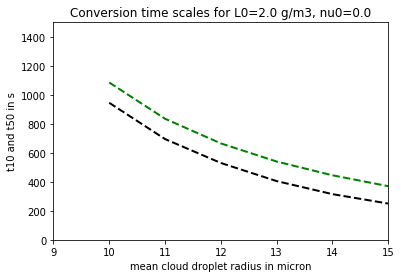

In [34]:

# chose initial liquid water content 
ii=5
nn=0

plt.plot(rc0*1e6, t10[0,ii,:,nn], 'k--', linewidth=2)
plt.plot(rc0*1e6, t10[1,ii,:,nn], 'k-', linewidth=2)
plt.plot(rc0*1e6, t50[0,ii,:,nn], 'g--', linewidth=2)
plt.plot(rc0*1e6, t50[1,ii,:,nn], 'g-', linewidth=2)

Lini = qc0_data[ii]*1e3

plt.title('Conversion time scales for L0=%3.1f'%Lini+' g/m3, nu0=%2.1f'%nu0[nn])

plt.ylabel('t10 and t50 in s')
plt.xlabel('mean cloud droplet radius in micron')

plt.xlim(9,15)  # 9 micron was not in the training data  
plt.ylim(0,1500)

plt.yscale('linear')
plt.xscale('linear')
plt.show()

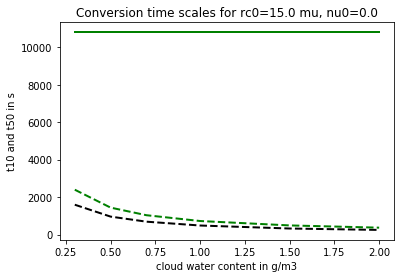

In [35]:

# chose initial drop radius
jj=5

plt.plot(qc0*1e3, t10[0,:,jj,nn], 'k--', linewidth=2)
plt.plot(qc0*1e3, t10[1,:,jj,nn], 'k-', linewidth=2)
plt.plot(qc0*1e3, t50[0,:,jj,nn], 'g--', linewidth=2)
plt.plot(qc0*1e3, t50[1,:,jj,nn], 'g-', linewidth=2)

Lini = qc0_data[jj]*1e3
Rini = rc0_data[jj]*1e6

plt.title('Conversion time scales for rc0=%3.1f'%Rini+' mu, nu0=%2.1f'%nu0[nn])

plt.ylabel('t10 and t50 in s')
plt.xlabel('cloud water content in g/m3')

plt.yscale('linear')
plt.xscale('linear')
plt.show()

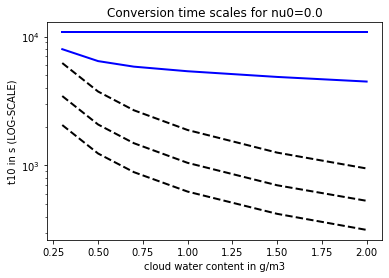

In [36]:
for jj in range(0,nrc,2):
    plt.plot(qc0*1e3, t10[0,:,jj,nn], 'k--', linewidth=2)
    plt.plot(qc0*1e3, t10[1,:,jj,nn], 'b-', linewidth=2)

Lini = qc0_data[jj]*1e3
Rini = rc0_data[jj]*1e6

plt.title('Conversion time scales for nu0=%2.1f'%nu0[nn])

plt.ylabel('t10 in s (LOG-SCALE)')
plt.xlabel('cloud water content in g/m3')

plt.yscale('log')
plt.xscale('linear')
plt.show()

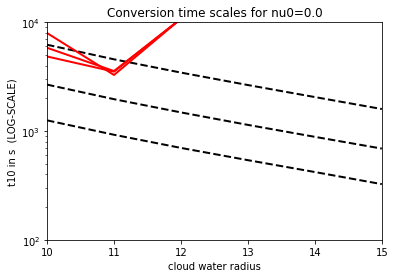

In [37]:
for ii in range(0,nqc,2):
    plt.plot(rc0*1e6, t10[0,ii,:,nn], 'k--', linewidth=2)
    plt.plot(rc0*1e6, t10[1,ii,:,nn], 'r-', linewidth=2)

Lini = qc0_data[ii]*1e3

plt.title('Conversion time scales for nu0=%2.1f'%nu0[nn])

plt.ylabel('t10 in s  (LOG-SCALE)')
plt.xlabel('cloud water radius')

plt.xlim(10,15)  # 9 micron was not in the training data  
plt.ylim(100,1e4)

plt.yscale('log')
plt.xscale('linear')
plt.show()

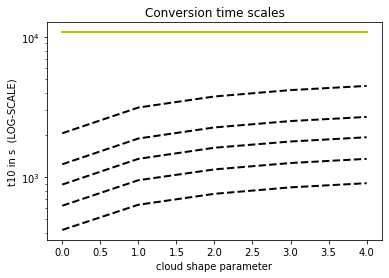

In [38]:
for ii in range(0,nnu,1):
    plt.plot(nu0, t10[0,ii,jj,:], 'k--', linewidth=2)
    plt.plot(nu0, t10[1,ii,jj,:], 'y-', linewidth=2)

Lini = qc0_data[ii]*1e3

plt.title('Conversion time scales')

plt.ylabel('t10 in s  (LOG-SCALE)')
plt.xlabel('cloud shape parameter')

plt.yscale('log')
plt.xscale('linear')
plt.show()

# Some quick time series plots

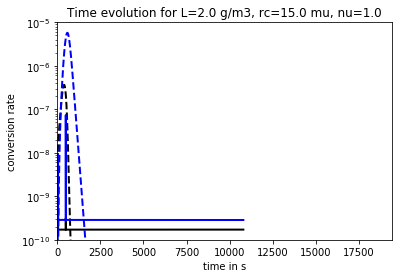

In [39]:

jj=5
ii=5
nn=1

xmax = 1.8 * np.max(t50[:,jj,ii,nn])
qmax = qc0_data[jj]

plt.plot(time, AU[0,jj,ii,nn,:], 'k--', linewidth=2)
plt.plot(time, AU[1,jj,ii,nn,:], 'k-', linewidth=2)
plt.plot(time, AC[0,jj,ii,nn,:], 'b--', linewidth=2)
plt.plot(time, AC[1,jj,ii,nn,:], 'b-', linewidth=2)

Lini = qc0_data[jj]*1e3
Rini = rc0_data[ii]*1e6
NUini = nu0_data[nn]

plt.title('Time evolution for L=%3.1f'%Lini+' g/m3, rc=%3.1f'%Rini+' mu, nu=%2.1f'%NUini)
plt.xlabel('time in s')
plt.ylabel('conversion rate')
plt.ylim(1e-10,1e-5)  
plt.xlim(0,xmax)  

plt.yscale('log')
plt.xscale('linear')
plt.show()

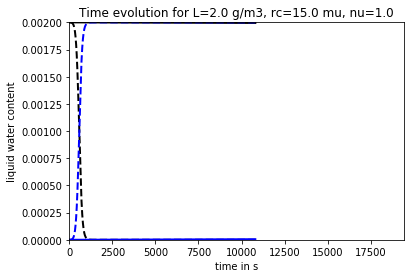

In [40]:
plt.plot(time, qc_data[0,jj,ii,nn,:], 'k--', linewidth=2)
plt.plot(time, qc_data[1,jj,ii,nn,:], 'k-', linewidth=2)
plt.plot(time, qr_data[0,jj,ii,nn,:], 'b--', linewidth=2)
plt.plot(time, qr_data[1,jj,ii,nn,:], 'b-', linewidth=2)

plt.title('Time evolution for L=%3.1f'%Lini+' g/m3, rc=%3.1f'%Rini+' mu, nu=%2.1f'%NUini)
plt.xlabel('time in s')
plt.ylabel('liquid water content')
plt.ylim(0,qmax)  
plt.xlim(0,xmax)  

plt.yscale('linear')
plt.xscale('linear')
plt.show()